# Bayesian Optimisation in Engineering and Product Design

<img src="img/examples.png" style="width: 100%;"/>

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as so
from pyDOE import lhs

In [2]:
#%matplotlib inline
#%config InlineBackend.close_figures=False

In [3]:
class GaussianProcess():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.eps = np.finfo(float).eps

    def get_covar(self, x, theta):
        n, m = x.shape
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                D = (1/theta[0:m]) * (x[i] - x[j]) ** 2
                K[i,j] = np.exp(-sum(D))
                K[j,i] = K[i,j]
        return K + theta[m]*np.eye(n) + np.eye(n)
    
    def train(self):
        n, m = self.x.shape
        bounds = list(zip([0.01]*m, [10]*m))
        bounds.append((self.eps, np.var(self.y)))
        x0 = [0.1] * m 
        x0.append(10e-6 * np.var(self.y))
        result = so.minimize(self._nl, x0=x0, bounds=bounds)
        self.theta = result.x
        
    def _nl(self, theta):
        n, m = self.x.shape
        K = self.get_covar(self.x, theta)
        try:
            L = np.linalg.cholesky(K)
        except np.linalg.linalg.LinAlgError:
            return 10e4
        Ly = np.linalg.solve(L, self.y)
        _, ldetK = np.linalg.slogdet(K)
        ll = -(n/2) * np.log(np.dot(Ly.T, np.linalg.solve(L, self.y))) - (1/2) * ldetK
        return -ll 
        
    def predict(self, xpred):
        n, m = self.x.shape
        if self.theta is None:
            raise 'Need to train before predict'
        K = self.get_covar(self.x, self.theta)
        K_xpred = self.get_covar(xpred, self.theta)

        npred = len(xpred)
        K_aug = np.zeros((npred, n))
        for i in range(npred):
            for j in range(n):
                D = (1/self.theta[0:m]) * (xpred[i] - self.x[j]) ** 2
                K_aug[i,j] = np.exp(-sum(D))
                
        # using chol
        L = np.linalg.cholesky(K)
        Lr = np.linalg.solve(L, K_aug.T)
        mubar = np.dot(Lr.T, np.linalg.solve(L, self.y))
        s2bar = np.clip(K_xpred - np.dot(Lr.T, np.linalg.solve(L, K_aug.T)), 1e-10, np.inf)
        sbar = np.sqrt(np.abs(np.diag(s2bar)))
        return mubar.flatten(), sbar.flatten()
    
    def CDF(self, x):
        return 0.5 * (1 + self.erf(x * np.sqrt(2))) 
            
    def PDF(self, x):
        return np.exp(-0.5 * x**2) / np.sqrt(2*np.pi)
    
    def erf(self, z):
        t = 1.0 / (1.0 + 0.5 * np.abs(z))
        # use Horner's method
        ans = 1 - t * np.exp( -z*z -  1.26551223 +
                                    t * ( 1.00002368 +
                                    t * ( 0.37409196 + 
                                    t * ( 0.09678418 + 
                                    t * (-0.18628806 + 
                                    t * ( 0.27886807 + 
                                    t * (-1.13520398 + 
                                    t * ( 1.48851587 + 
                                    t * (-0.82215223 + 
                                    t * ( 0.17087277))))))))))
        
        if isinstance(ans, np.float64): 
            if z < 0.0:
                ans = -ans
        else:
            ans[z<0.0] = -ans[z<0.0]            
        return ans
    
    def ei(self, xpred):
        ypred, spred = self.predict(xpred)            
        ymin = min(self.y)
        ydiff = ymin - ypred
        Z = ydiff / spred
        exp_imp = (ydiff * self.CDF(Z)) + (spred * self.PDF(Z))
        return exp_imp
    
    def negei(self, xpred):
        exp_imp = self.ei(np.array([xpred]))
        return -exp_imp
    
    def add_data(self, x, y):
        self.x = np.vstack([self.x, x])
        self.y = np.vstack([self.y, y])
        self.train()  

In [4]:
def simple_model(x):
    f = ((6*x - 2)**2) * np.sin(12*x - 4) 
    return f

In [5]:
def multistart_minimize(fun, bounds):
    m = len(bounds)
    n_starts = m * 20
    random_starts = lhs(m,n_starts)#np.random.uniform(size=(n_starts,m)) #need to scale this to x
    starts = np.zeros((n_starts,m))
    for d in range(m):
        lb = bounds[d][0]
        ub = bounds[d][1]
        starts[:,d] = random_starts[:,d] * (ub - lb) + lb
    ymin = np.inf
    xmin = 0
    for start in starts:
        result = so.minimize(fun, x0=start, bounds=bounds)
        if result.fun < ymin:
            ymin = result.fun
            xmin = np.array(result.x)
    return xmin, ymin

In [6]:
from ipywidgets import widgets
from IPython.display import display,clear_output

plt.rcParams['figure.figsize'] = (20, 8)


np.random.seed(1317)
n_obs = 5
x_obs = lhs(1, n_obs)
y_obs = simple_model(x_obs)
gp = GaussianProcess(x=x_obs, y=y_obs)
gp.train()

ni = 100
xi = np.linspace(0,1,ni).reshape(ni,1)
yi = simple_model(xi)

mubar, sbar = gp.predict(xi)
ei = gp.ei(xi)

class Clicks:
    def __init__(self, gp):
        self.gp = gp
        self.i = 0
    
    def click(self, b):
        if b is None:
            mubar = np.zeros(len(xi))
            sbar = np.ones(len(xi))
            ax1.scatter(-1,-1, label='Observations')
            ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
            ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
            ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
            ax1.set_xlim(0,1)
            ax1.set_xlabel('Design parameter value $x_1$')
            ax1.set_ylabel('Objective value $f(x_1)$')
            ax1.legend()
            ax1.set_title('Observations and GP prediction')
            ax2.set_xlim(0,1)
            ax2.axis('off')
        else:
            if self.i == 0:
                mubar, sbar = gp.predict(xi)
                ei = gp.ei(xi)
                
                ax1.clear()
                ax2.clear()
                ax1.scatter(self.gp.x, self.gp.y, label='Observations')
                ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
                ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
                ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
                ax1.set_xlim(0,1)
                ax1.set_xlabel('Design parameter value $x_1$')
                ax1.set_ylabel('Objective value $f(x_1)$')
                ax1.legend()
                ax1.set_title('Observations and GP prediction')
                ax2.plot(xi, ei, color=(1.0, 0.56, 0.06))
                ax2.set_title('Acquisition function')
                ax2.set_xlim(0,1)
                ax2.set_xlabel('Design parameter value $x_1$')
                ax2.set_ylabel('Expected improvement $EI(f(x_1) < y_{min})$')
                self.i = 1
            else:
                newx, _ = multistart_minimize(self.gp.negei, bounds=[(0,1)])
                newy = simple_model(newx)
                self.gp.add_data(newx, newy)
                mubar, sbar = gp.predict(xi)
                ei = gp.ei(xi)

                ax1.clear()
                ax2.clear()
                ax1.scatter(self.gp.x, self.gp.y, label='Observations')
                ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
                ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
                ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
                ax1.set_xlim(0,1)
                ax1.set_xlabel('Design parameter value $x_1$')
                ax1.set_ylabel('Objective value $f(x_1)$')
                ax1.legend()
                ax1.set_title('Observations and GP prediction')
                ax2.plot(xi, ei, color=(1.0, 0.56, 0.06))
                ax2.set_title('Acquisition function')
                ax2.set_xlim(0,1)
                ax2.set_xlabel('Design parameter value $x_1$')
                ax2.set_ylabel('Expected improvement $EI(f(x_1) < y_{min})$')
        with out:
            clear_output(wait=True)
            display(ax.figure)

plt.ioff()
ax = plt.gca()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

out = widgets.Output()
button = widgets.Button(description='Add update')

box=widgets.VBox(children=(out,button))

clicks = Clicks(gp)
button.on_click(clicks.click)

In [7]:
display(box)
clicks.click(None)

<img src="img/ductscene.png" style="width: 1000px; margin-left: auto; margin-right: auto;"/>

<img src="img/animated.gif" style="height: 1000px; margin-left: auto; margin-right: auto;"/>

<img src="img/fan_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<img src="img/final_shoe.jpg" style="width: 1200px; margin-left: auto; margin-right: auto;"/>

<img src="img/shoe_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

## Using Bayesian optimisation in aesthetics

In [8]:
class PreferenceBasedGP(object):
    def __init__(self, r, c, z, theta):
        self.r = r
        self.c = c
        self.z = z
        self.theta = theta
        self.preferences, self.X = self._get_preferences()
        self.L = self._get_L()
        self.Y = None
        self.Y_guess = None
    
    def _get_preferences(self):
        x2ind = {}
        ind = 0
        prefinds = []
        for i in range(len(self.z)):
            if self.r[i] not in x2ind:
                x2ind[self.r[i]] = ind
                ind += 1
            if self.c[i] not in x2ind:
                x2ind[self.c[i]] = ind
                ind += 1
            prefinds.append((x2ind[self.r[i]], x2ind[self.c[i]], self.z[i]))
        X = np.array([[x] for x, _ in sorted(x2ind.items(), key=lambda x:x[1])])
        return prefinds, X
    
    def get_covar(self, x, theta):
        n, m = x.shape
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                D = (1/theta[0:m]) * (x[i] - x[j]) ** 2
                K[i,j] = np.exp(-sum(D))
                K[j,i] = K[i,j]
        return K + theta[m]*np.eye(n) + np.eye(n)
    
    def _get_L(self):
        K = self.get_covar(self.X, self.theta)
        L = np.linalg.cholesky(K)
        return L
    
    def _get_initial_guess(self):
        vs = set(self.r)
        lastY = {}
        ymin = -0.5
        ymax = 0.5
        
        if self.Y is None:
            start = []
            for x in self.X.tolist():
                if tuple(x) in lastY:
                    start.append(lastY[tuple(x)])
                else:
                    if tuple(x) in vs:
                        start.append(ymax)
                    else:
                        start.append(ymin)
        else:
            for x, y in zip(self.X.tolist(), self.Y):
                lastY[tuple(x)] = y
            start = []
            for x in self.X.tolist():
                if tuple(x) in lastY:
                    start.append(lastY[tuple(x)])
                else:
                    if tuple(x) in vs:
                        start.append(ymax)
                    else:
                        start.append(ymin)
        return start
    
    def CDF(self, x):
        return 0.5 * (1 + self.erf((x) * 0.707106))
            
    def PDF(self, x):
        return  np.exp(-(x**2/2)) * 0.398942
    
    def erf(self, z):
        t = 1.0 / (1.0 + 0.5 * np.abs(z))
        # use Horner's method
        ans = 1 - t * np.exp( -z*z -  1.26551223 +
                                    t * ( 1.00002368 +
                                    t * ( 0.37409196 + 
                                    t * ( 0.09678418 + 
                                    t * (-0.18628806 + 
                                    t * ( 0.27886807 + 
                                    t * (-1.13520398 + 
                                    t * ( 1.48851587 + 
                                    t * (-0.82215223 + 
                                    t * ( 0.17087277))))))))))
        
        if isinstance(ans, np.float64): 
            if z < 0.0:
                ans = -ans
        else:
            ans[z<0.0] = -ans[z<0.0]            
        return ans
            
    
    def S(self, x):
        logCDFs = 0.
        sigma = 1
        epsilon = 1e-10
        Z = np.sqrt(2) * sigma
        for v, u, d in self.preferences:
            logCDFs += (d+1) * np.log(self.CDF((x[v]-x[u])/Z)+epsilon)
            Lx = np.linalg.solve(self.L, x)
            val = -logCDFs + np.dot(Lx, Lx)/2
        return val
        
    def train(self):
        y_guess = self._get_initial_guess()
        result = so.minimize(self.S, y_guess)
        self.Y = result.x
        
    def predict(self, xpred):
        n, m = self.X.shape
        if self.theta is None:
            raise 'Need to train before predict'
        K = self.get_covar(self.X, self.theta)
        K_xpred = self.get_covar(xpred, self.theta)

        npred = len(xpred)
        K_aug = np.zeros((npred, n))
        for i in range(npred):
            for j in range(n):
                D = (1/self.theta[0:m]) * (xpred[i] - self.X[j]) ** 2
                K_aug[i,j] = np.exp(-sum(D))
        
        # using chol
        L = np.linalg.cholesky(K)
        Lr = np.linalg.solve(L, K_aug.T)
        mubar = np.dot(Lr.T, np.linalg.solve(L, self.Y))
        s2bar = np.clip(K_xpred - np.dot(Lr.T, np.linalg.solve(L, K_aug.T)), 1e-10, np.inf)
        sbar = np.sqrt(np.abs(np.diag(s2bar)))
        return mubar.flatten(), sbar.flatten()
    
    def ei(self, xpred):
        ypred, spred = self.predict(xpred)
        ymax = max(self.Y)
        ydiff = ypred - ymax
        Z = ydiff / spred
        exp_imp = (ydiff * self.CDF(Z)) + (spred * self.PDF(Z))
        return exp_imp
    
    def negei(self, xpred):
        exp_imp = self.ei(np.array([xpred]))
        return -exp_imp
    
    def add_data(self, r, c, z):
        for i in r: self.r.append(i)
        for j in c: self.c.append(j)
        for k in z: self.z.append(k)
        self.preferences, self.X = self._get_preferences()
        self.L = self._get_L()
        self.train()    

In [9]:
from PIL import Image

def change_contrast(x):
    img = Image.open("img/warhol.jpeg")
    img.load()
    level = (1000 * x) - 500
    factor = (259 * (level+255)) / (255 * (259-level))
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            color = img.getpixel((x, y))
            new_color = tuple(int(factor * (c-128) + 128) for c in color)
            img.putpixel((x, y), new_color)
    return img

In [10]:
plt.close()
np.random.seed(30786)
n = 5
xn = lhs(1,n)
left_value = np.random.random()
right_value = xn[0][0]

pref_out_left=widgets.Output()
pref_out_right=widgets.Output()

pref_button_left=widgets.Button(description='Left is best')
pref_button_right=widgets.Button(description='Right is best')

pref_box=widgets.HBox(children=(widgets.VBox(children=(pref_out_left, pref_button_left)),
                            widgets.VBox(children=(pref_out_right, pref_button_right))))

class PrefClicks:
    def __init__(self, left_value, right_value, xn):
        self.i = 0
        self.left_value = left_value
        self.right_value = right_value
        self.xn = xn
        self.n = len(xn)
        self.r = []
        self.c = []
        self.z = []
        #self.gp = None
    
    def click_left(self, b):
        if b is not None:
            self.i += 1
            self.r.append(self.left_value)
            self.c.append(self.right_value)
            self.z.append(1)
        if self.i == self.n:
            self.gp = PreferenceBasedGP(r=self.r, c=self.c, z=self.z, theta=np.array([0.05, 0.005]))
            self.gp.train()
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.right_value = xmin[0]
        elif self.i > self.n:
            self.gp.add_data(r=[self.left_value], c=[self.right_value], z = [1])
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.right_value = xmin[0]
        else:
            if self.i > 0:
                self.right_value = self.xn[self.i][0]
        img_right = change_contrast(self.right_value)
        ax_right.imshow(np.asarray(img_right))
        with pref_out_right:
            clear_output(wait=True)
            display(ax_right.figure)

    def click_right(self, b):
        if b is not None:
            self.i += 1
            self.r.append(self.left_value)
            self.c.append(self.right_value)
            self.z.append(0)
        if self.i == self.n:
            self.gp = PreferenceBasedGP(r=self.r, c=self.c, z=self.z, theta=np.array([0.05, 0.005]))
            self.gp.train()
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.left_value = xmin[0]
        elif self.i > self.n:
            self.gp.add_data(r=[self.left_value], c=[self.right_value], z = [0])
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.left_value = xmin[0]
        else:
            if self.i > 0:
                self.left_value = self.xn[self.i][0]
        img_left = change_contrast(self.left_value)
        ax_left.imshow(np.asarray(img_left))
        with pref_out_left:
            clear_output(wait=True)
            display(ax_left.figure)

plt.cla()
plt.ioff()
ax_left = plt.gca()
ax_left.axis('off')

plt.ioff()
ax_right = plt.gca()
ax_right.axis('off')

pref_clicks = PrefClicks(left_value, right_value, xn)
pref_button_left.on_click(pref_clicks.click_left)
pref_button_right.on_click(pref_clicks.click_right)

In [11]:
display(pref_box)
pref_clicks.click_left(None)
pref_clicks.click_right(None)

In [12]:
def gp_pref():
    ni = 50
    xi = np.linspace(0, 1, ni).reshape(ni,1)

    gp_pref = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.scatter(pref_clicks.gp.X, pref_clicks.gp.Y, label='Observations')
    ypred, spred = pref_clicks.gp.predict(xi)
    ei = pref_clicks.gp.ei(xi)
    plt.plot(xi, ypred, color=(0.122, 0.529, 0.8), label='GP utility prediction')
    plt.fill_between(xi.flatten(), ypred+2*spred, ypred-2*spred, color=(0.122, 0.529, 0.8, 0.2))
    plt.xlabel('Design parameter value $x_1$')
    plt.ylabel('Objective value $f(x_1)$')  

    plt.subplot(122)
    plt.plot(xi, ei, color=(1.0, 0.56, 0.06))
    plt.xlabel('Design parameter value $x_1$')
    plt.ylabel('Expected improvement $EI(f(x_1) > y_{max})$')
    return gp_pref

In [13]:
#import pandas as pd
#pd.DataFrame({'r': pref_clicks.gp.r, 'c': pref_clicks.gp.c, 'z': pref_clicks.gp.z})

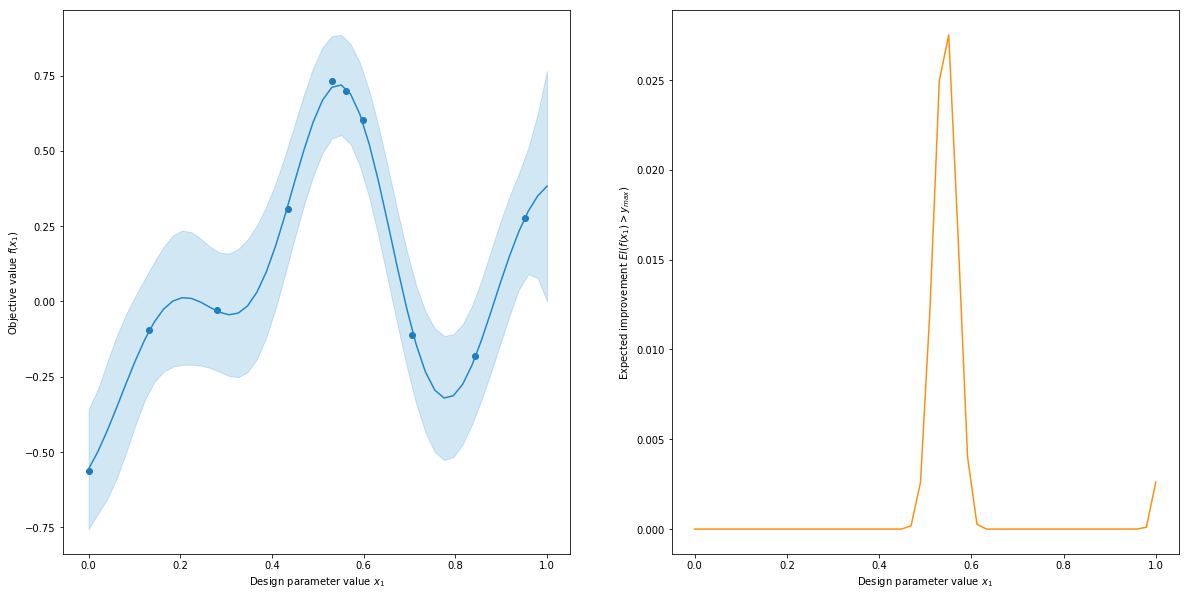

In [15]:
gp_pref()

<img src="img/smoke.gif" style="height:600px; margin-left: auto; margin-right: auto;"/>

<img src="img/smoke_step.gif" style="width:100%; margin-left: auto; margin-right: auto;"/>

<img src="img/smoke_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

... full talk at pydata2018

https://youtu.be/DUWQiLAvr5I

In [ ]:
import subprocess
def get_plume(x):
    source_velocity = 4*x[0]
    normal_velocity = 6*x[1] - 2
    file_name = 'sample_test' 
    # run simulation
    p = subprocess.Popen('blender --python run_blender.py -- {} {} {}'.format(source_velocity, normal_velocity, file_name))

In [ ]:
#get_plume([0.9195404,  0.03777169])